In [1]:
import numpy as np
import io
import os
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import copy
import re
import matplotlib.pyplot as plt
from tabulate import tabulate
from itertools import groupby
import inspect
import matplotlib.colors as mc

In [2]:
# importing all vcf files paths and storing them in three different lists depending on the group of the individuals

my_path = "/home/yboulkaid/Documents/sample_data/pgtest.simulation_1000vars_100samps/calls/"
#my_path = "/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"
# my_path = "/Users/boulkaid/Documents/4A/pangenomes/pgtest.data/calls/"
all_vcf = os.listdir(my_path)
g0_vcf = []
g1_vcf = []
for i in all_vcf:
    if 'g0' in i:
        g0_vcf.append(i)
    elif 'g1' in i:
        g1_vcf.append(i)

In [3]:
# function to create a data frame from a vcf file

def make_vcf_df(path):
    with open(path, 'r') as file:
        lines = [i for i in file if not i.startswith('##')]
    return pd.read_csv(io.StringIO(''.join(lines)),
                       dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str, 'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t').rename(columns={'#CHROM': 'CHROM'})

In [4]:
# creating three data frames for all vcfs, g0 and g1 vcfs

all_vcf_df = []
for i in all_vcf:
    all_vcf_df.append(make_vcf_df(my_path + i))

g0_vcf_df = []
for i in g0_vcf:
    g0_vcf_df.append(make_vcf_df(my_path + i))

g1_vcf_df = []
for i in g1_vcf:
    g1_vcf_df.append(make_vcf_df(my_path + i))

In [5]:
# annex function used later to create the "snarl data frames"
# old 

'''def paths(which_vcf_df):
    possible_paths = []
    for i in range(len(which_vcf_df["INFO"])):
        info = which_vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', info)
        if m:
            found = m.group(1)
        possible_paths.append(found)

    for i in range(len(possible_paths)):
        possible_paths[i] = possible_paths[i].split(',')

    ########################################################################
    paths_taken = []
    for i in which_vcf_df["SAMPLE"]:
        found = i[0:3]
        paths_taken.append(found)

    for i in range(len(paths_taken)):
        paths_taken[i] = paths_taken[i].split('/')
        for j in range(len(paths_taken[i])):
            paths_taken[i][j] = int(paths_taken[i][j])

    ########################################################################
    combined_paths = copy.deepcopy(paths_taken)

    for i in range(len(paths_taken)):
        combined_paths[i][0] = possible_paths[i][paths_taken[i][0]]
        combined_paths[i][1] = possible_paths[i][paths_taken[i][1]]
        
    ########################################################################
    possible_paths = sum(possible_paths, [])
    for i in range(len(possible_paths)):
        if possible_paths[i][0] == '>':
            possible_paths[i] = possible_paths[i][1:]
            
    combined_paths = sum(combined_paths, [])
    for i in range(len(combined_paths)):
        if combined_paths[i][0] == '>':
            combined_paths[i] = combined_paths[i][1:]

    paths_taken = sum(paths_taken, [])

    return possible_paths, paths_taken, combined_paths''';

'def paths(which_vcf_df):\n    possible_paths = []\n    for i in range(len(which_vcf_df["INFO"])):\n        info = which_vcf_df["INFO"][i]\n        m = re.search(\'AT=>(.+?);DP\', info)\n        if m:\n            found = m.group(1)\n        possible_paths.append(found)\n\n    for i in range(len(possible_paths)):\n        possible_paths[i] = possible_paths[i].split(\',\')\n\n    ########################################################################\n    paths_taken = []\n    for i in which_vcf_df["SAMPLE"]:\n        found = i[0:3]\n        paths_taken.append(found)\n\n    for i in range(len(paths_taken)):\n        paths_taken[i] = paths_taken[i].split(\'/\')\n        for j in range(len(paths_taken[i])):\n            paths_taken[i][j] = int(paths_taken[i][j])\n\n    ########################################################################\n    combined_paths = copy.deepcopy(paths_taken)\n\n    for i in range(len(paths_taken)):\n        combined_paths[i][0] = possible_paths[i][paths_tak

In [6]:
# annex function used later to create the "snarl data frames"
def flatten(xss):
    return [x for xs in xss for x in xs]


def paths(which_vcf_df):
    possible_paths = []
    for i in range(len(which_vcf_df["INFO"])):
        info = which_vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', info)
        if m:
            found = m.group(1)
        possible_paths.append(found)

    for i in range(len(possible_paths)):
        possible_paths[i] = possible_paths[i].split(',')
    ########################################################################
    paths_taken = []
    for i in which_vcf_df.iloc[:, -1]:
        found = i[0:3]
        paths_taken.append(found)

    for i in range(len(paths_taken)):
        paths_taken[i] = paths_taken[i].split('/')
        for j in range(len(paths_taken[i])):
            paths_taken[i][j] = int(paths_taken[i][j])

    ########################################################################
    combined_paths = copy.deepcopy(paths_taken)

    for i in range(len(paths_taken)):
        combined_paths[i][0] = possible_paths[i][paths_taken[i][0]]
        combined_paths[i][1] = possible_paths[i][paths_taken[i][1]]
    ########################################################################
    # possible_paths = sum(possible_paths, [])
    possible_paths = flatten(possible_paths)
    #print(len(possible_paths))
    for i in range(len(possible_paths)):
        if possible_paths[i][0] == '>' or possible_paths[i][0] == '<':
            possible_paths[i] = possible_paths[i][1:]
    #combined_paths = sum(combined_paths, [])
    combined_paths = flatten(combined_paths)
    for i in range(len(combined_paths)):
        if combined_paths[i][0] == '>' or possible_paths[i][0] == '<':
            combined_paths[i] = combined_paths[i][1:]
    # paths_taken = sum(paths_taken, [])
    paths_taken = flatten(paths_taken)

    return possible_paths, paths_taken, combined_paths

In [7]:
# annex functions that identifies the first and last node of a snarl

def start_node(which_snarl):
    if which_snarl[0] == '>':
        S = re.search('>(.+?)>', which_snarl)
        if S:
            s = S.group(1)
    else:
        S = re.search('(.+?)>', which_snarl)
        if S:
            s = S.group(1)
    return s


def end_node(which_snarl):
    if which_snarl[0] == '>':
        E = re.search('.+>(.*)', which_snarl)
        if E:
            e = E.group(1)
    else:
        E = re.search('.+>(.*)', which_snarl)
        if E:
            e = E.group(1)
    return e

In [8]:
# function to create a "snarl data frame" from a list of vcf data frames

def make_snarl_df_from_vcf(which_vcf_list):
    df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken', 'index provisoire'])

    ####### filling in the 'snarl' column #######
    # computing all possible paths using the 'paths' function defined earlier
    possible_paths = [paths(i)[0] for i in all_vcf_df]
    possible_paths = sum(possible_paths, [])
    possible_paths = list(set(possible_paths))
    
    df['snarl'] = possible_paths

    ####### filling in the 'times taken' column #######
    for i in range(len(possible_paths)):
        df.loc[i, 'times taken'] = 0
        
    combine_counts = []
    for i in range(len(which_vcf_list)):
        combined_paths = paths(which_vcf_list[i])[2]
        combine_counts.extend((x, combined_paths.count(x)) for x in set(combined_paths))

    snarl_dict = {str(snarl): index for index, snarl in enumerate(df['snarl'])}

    for snarl, count in combine_counts:
        if snarl in snarl_dict:
            df.loc[snarl_dict[snarl], "times taken"] += count

    ####### filling in the 'snarl index' column #######
    for i in range(len(df['snarl index'])):
        s = start_node(df['snarl'][i])
        e = end_node(df['snarl'][i])
        df.loc[i, "snarl index"] = s + '>' + e
        df.loc[i, "index provisoire"] = int(s)
    # sorting the indexes in asceding order
    df.set_index('index provisoire', inplace=True, drop=True)
    df.sort_index(inplace=True)
    df.reset_index()
    df.set_index('snarl index', inplace=True, drop=True)
    
    return df

In [9]:
# creating three data frames for all vcfs, g0 and g1 vcfs

all_df = make_snarl_df_from_vcf(all_vcf_df)
g0_df = make_snarl_df_from_vcf(g0_vcf_df)
g1_df = make_snarl_df_from_vcf(g1_vcf_df)

In [10]:
# functions used to perform the tests and compute the p-values

def make_contingency_table(which_snarl_df, which_g0_df, which_g1_df, which_snarl):
    n = which_snarl_df.index.value_counts()[which_snarl]
    possible_paths_for_which_snarl = []
    for i in range(n):
        possible_paths_for_which_snarl.append(which_g0_df.loc[which_snarl]['snarl'].iloc[i])
        
    table = pd.DataFrame(columns=['g0', 'g1'], index=possible_paths_for_which_snarl)
    
    for i in range(len(possible_paths_for_which_snarl)):
        table.at[possible_paths_for_which_snarl[i], 'g1'] = which_g1_df.loc[which_snarl]['times taken'].iloc[i]
        table.at[possible_paths_for_which_snarl[i], 'g0'] = which_g0_df.loc[which_snarl]['times taken'].iloc[i]
    return table


def chi2(table):
    return chi2_contingency(table).pvalue


def fish(table):
    return fisher_exact(table).pvalue

In [11]:
# from a complete contingency table (ie. that takes all possible paths into account) obtain a simplified table that only two paths into account (the direct one and all other ones)
# ex: snarl 1>6, possible paths 1>6, 1>2>3>5>6, 1>2>4>5>6 become 1>6 and 1>2>*>5>6

def make_square_table(which_snarl_df, which_g0_df, which_g1_df, which_snarl):
    table = make_contingency_table(which_snarl_df, which_g0_df, which_g1_df, which_snarl)
    if len(table) > 2:
        other_paths_g0 = other_paths_g1 = direct_path_g0 = direct_path_g1 = 0
        for i in range(len(table)):
            if table.index[i] != which_snarl:
                other_paths_g0 += table['g0'].iloc[i]
                other_paths_g1 += table['g1'].iloc[i]
            else:
                direct_path_g0 = table['g0'].iloc[i]
                direct_path_g1 = table['g1'].iloc[i]

        # renaming the paths
        longest_path = max(table.index, key=len)
        S = re.search('(.+?>.+?)>', longest_path)
        if S:
            s = S.group(1)
        E = re.search('.+>(.+?>.*)', longest_path)
        if E:
            e = E.group(1)
        other = s + '> * >' + e
        
        # creating final table
        new_table = pd.DataFrame({'g0': [direct_path_g0, other_paths_g0], 'g1': [direct_path_g1, other_paths_g1]}, index=[which_snarl, other])
        return new_table
    else:
        return table

In [12]:
# computing the p-values for all snarls

pval_list_complete_chi2 = []  # list of pvalues obtained from the complete contingency tables using chi2 test
pval_list_square_chi2   = []  # list of pvalues obtained from the square contingency tables using chi2 test
pval_list_square_fish   = []  # list of pvalues obtained from the square contingency tables using fisher test

for i in all_df.index.unique():
    table = make_contingency_table(all_df, g0_df, g1_df, i)
    table_to_modify = table.copy(deep=True)
    mask = (table['g0'] == 0) & (table['g1'] == 0)  # we have to use a mask to remove the rows where all values are equal to 0 in order to perform the chi2 test
    table_to_modify = table_to_modify[~mask]
    pval_list_complete_chi2.append([chi2(table_to_modify), i])

for i in all_df.index.unique():
    table = make_square_table(all_df, g0_df, g1_df, i)
    table_to_modify = table.copy(deep=True)
    mask = (table['g0'] == 0) & (table['g1'] == 0)
    table_to_modify = table_to_modify[~mask]
    pval_list_square_chi2.append([chi2(table_to_modify), i])

pval_list_square_fish = [[fish(make_square_table(all_df, g0_df, g1_df, i)), i] for i in all_df.index.unique()]

# checking that all pval_lists are the same size
print(len(pval_list_complete_chi2) == len(pval_list_square_chi2) == len(pval_list_square_fish))

True


In [13]:
threshold = 2


def make_smallest_pv_list(pval_list):
    frame = inspect.currentframe().f_back
    
    # Find the name of the variable in the calling frame
    var_name = None
    for name, value in frame.f_locals.items():
        if value is pval_list:
            var_name = name
            break

    res = [(-np.log10(pval_list[i][0]), pval_list[i][1]) for i in range(len(pval_list)) if -np.log10(pval_list[i][0]) > threshold]
    print('len ', var_name, ' : ', len(res))
    print(res)
    print('\n')
    return res

In [14]:
#  getting the smallest p-values in each list

smallest_pv_complete_chi2 = make_smallest_pv_list(pval_list_complete_chi2)
smallest_pv_square_chi2   = make_smallest_pv_list(pval_list_square_chi2)
smallest_pv_square_fish   = make_smallest_pv_list(pval_list_square_fish)

len  pval_list_complete_chi2  :  100
[(12.065928947183503, '66>69'), (3.6455969831885535, '92>106'), (10.32662106785295, '106>109'), (6.987750763405431, '112>115'), (3.6727235740817594, '115>118'), (7.092900592470356, '156>167'), (3.667991502407003, '189>191'), (2.0136104146384604, '197>211'), (2.0874495187348954, '217>220'), (2.676895659117547, '252>257'), (5.116354517665606, '273>281'), (2.6589173696478543, '297>302'), (18.254743976169237, '457>460'), (2.0293652287287864, '503>526'), (27.442639427497888, '589>592'), (10.767960526620298, '612>615'), (4.649632157320918, '706>723'), (5.805301518806456, '745>747'), (14.182194859450048, '747>755'), (20.679690655785276, '755>758'), (11.390503010754964, '766>768'), (8.001096252729017, '787>790'), (2.703401901617395, '852>855'), (4.200600258835404, '855>858'), (3.000623688049401, '880>883'), (2.0572262516821858, '893>901'), (10.37047390372832, '934>936'), (15.89401573191389, '936>939'), (3.016559469402346, '1008>1031'), (2.497264084376302, '

In [15]:
# function to create a p-value data frame from a list of p-values
def make_pval_df(which_pval_list, colors):
    pval_df = pd.DataFrame(columns=['snarl index', 'p-value', 'minuslog10pvalue', 'color', 'size'])
    for i in range(len(which_pval_list)):
        pval_df.loc[i, 'snarl index'] = which_pval_list[i][1]
        pval_df.loc[i, "p-value"] = which_pval_list[i][0]
        # if which_pval_list[i][0] != -1:
        pval_df.loc[i, "minuslog10pvalue"] = -np.log10(which_pval_list[i][0])
        # else:
        #   print('not ok')
    conditions = [(pval_df['minuslog10pvalue'] > threshold)]
    if colors == 'primary':
        choices = ['green']
        pval_df['color'] = np.select(conditions, choices, default='blue')
        pval_df['size'] = 30
    elif colors == 'secondary':
        choices = ['limegreen']
        pval_df['color'] = np.select(conditions, choices, default='cyan')
        pval_df['size'] = 10
    '''conditions = [(pval_df['minuslog10pvalue'] == -0.0),
                  (pval_df['minuslog10pvalue'] > threshold),
                  (pval_df.index % 2 == 0)]
    if colors == 'primary':
        choices = ['red', 'limegreen', 'blue']
        pval_df['color'] = np.select(conditions, choices, default='cyan')
        pval_df['size'] = 15
    elif colors == 'secondary':
        choices = ['orange', 'greenyellow', 'mediumorchid']
        pval_df['color'] = np.select(conditions, choices, default='hotpink')
        pval_df['size'] = 10'''
    pval_df.set_index('snarl index', inplace=True, drop=True)
    return pval_df

In [16]:
# creating the p-value data frames

pval_df_complete_chi2 = make_pval_df(pval_list_complete_chi2, 'primary')
pval_df_square_chi2 = make_pval_df(pval_list_square_chi2, 'primary')
pval_df_square_fish = make_pval_df(pval_list_square_fish, 'primary')

In [17]:
# function to verify that the sum of the columns in the contingency tables is always equal to the number of files

def contingence_somme_col(snarl_list, number_of_files):
    snarl_index_somme_pas_ok = []
    for i in snarl_list:
        if make_contingency_table(all_df, g0_df, g1_df, i).sum(axis=0).iloc[0] != number_of_files or make_contingency_table(all_df, g0_df, g1_df, i).sum(axis=0).iloc[1] != number_of_files:
            snarl_index_somme_pas_ok.append(i)
        if make_square_table(all_df, g0_df, g1_df, i).sum(axis=0).iloc[0] != number_of_files or make_square_table(all_df, g0_df, g1_df, i).sum(axis=0).iloc[1] != number_of_files:
            snarl_index_somme_pas_ok.append(i)

    if len(snarl_index_somme_pas_ok) == 0:
        print('bien ouej !')
    else:
        print('better luck next time...')


contingence_somme_col(all_df.index.unique(), 60)

better luck next time...


In [18]:
def manhattan_plot(which_pv_df, ax):
    ax.scatter(range(len(which_pv_df)), which_pv_df['minuslog10pvalue'], c=which_pv_df['color'], s=which_pv_df['size'])
    
    ax.set_xticks(range(len(which_pv_df)))
    ax.set_xticklabels(which_pv_df.index, rotation=90, size=10)
    ax.set_xlabel('snarl index')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title('manhattan plot')
    
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_color(which_pv_df['color'].iloc[i])
        if i % 2 == 0:
            label.set_y(-0.05)
        else:
            label.set_y(-0.02)
            
    unique_colors = which_pv_df['color'].unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in unique_colors]
    labels = [f'Group {color}' for color in unique_colors]
    ax.legend(handles, labels, title='Legend')


def histogram(which_pv_df, ax):
    ax.hist(which_pv_df['p-value'], color='blue')
    ax.set_title('histogram')
    ax.set_xlabel('p-value')
    ax.set_ylabel('frequency')

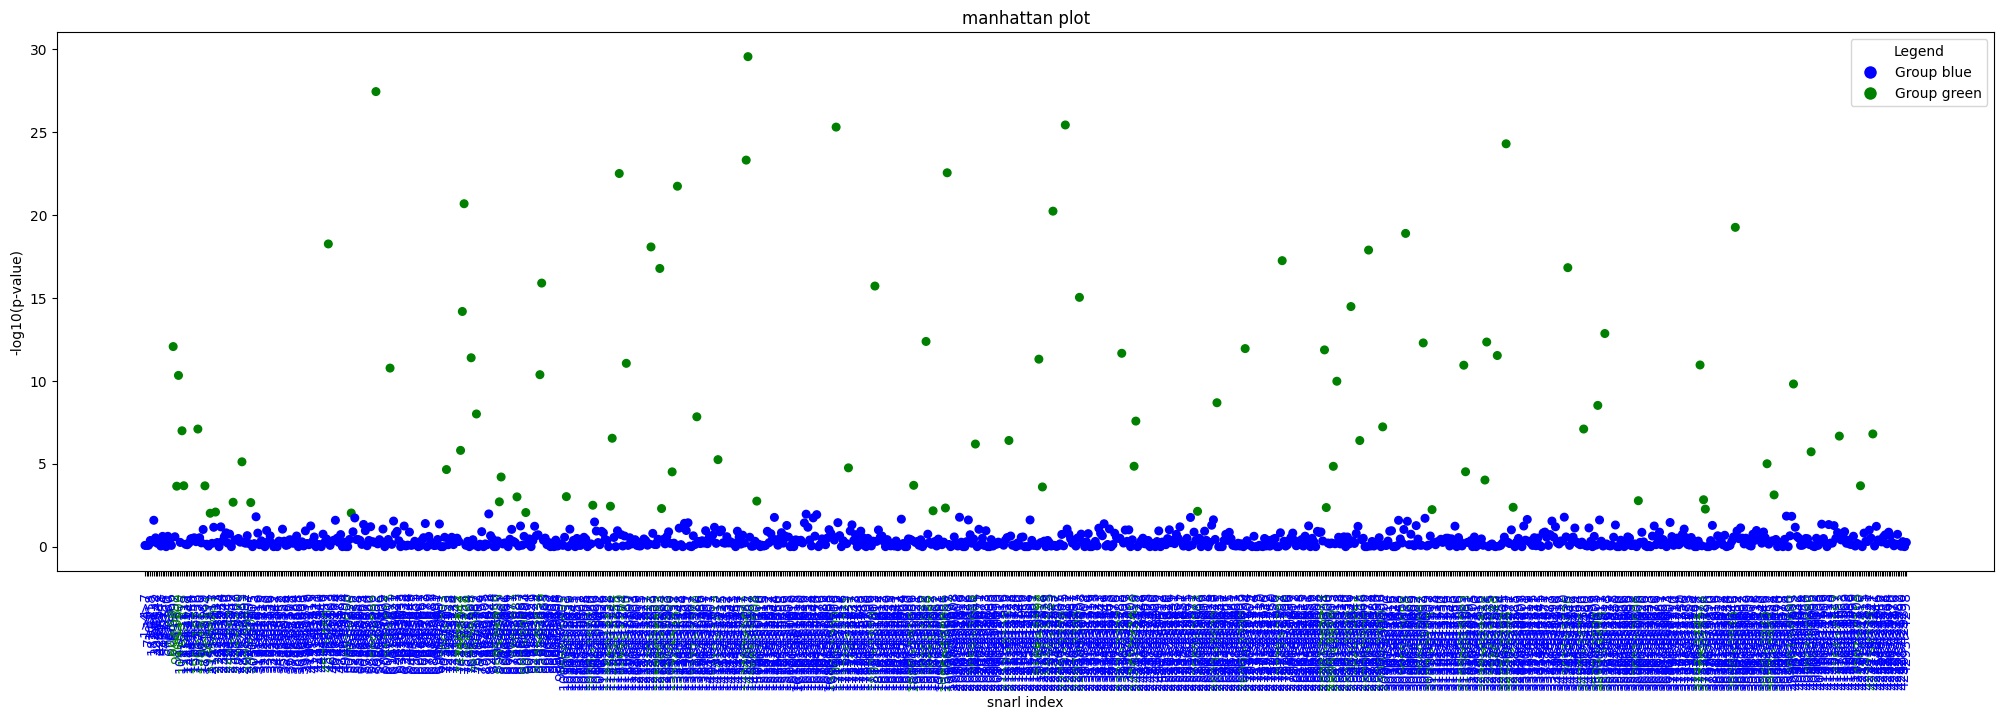

In [19]:
pvdftest = make_pval_df(pval_list_complete_chi2, 'secondary')

fig, axs = plt.subplots(1, 1, figsize=(25, 7))

man1 = manhattan_plot(pval_df_complete_chi2, axs)


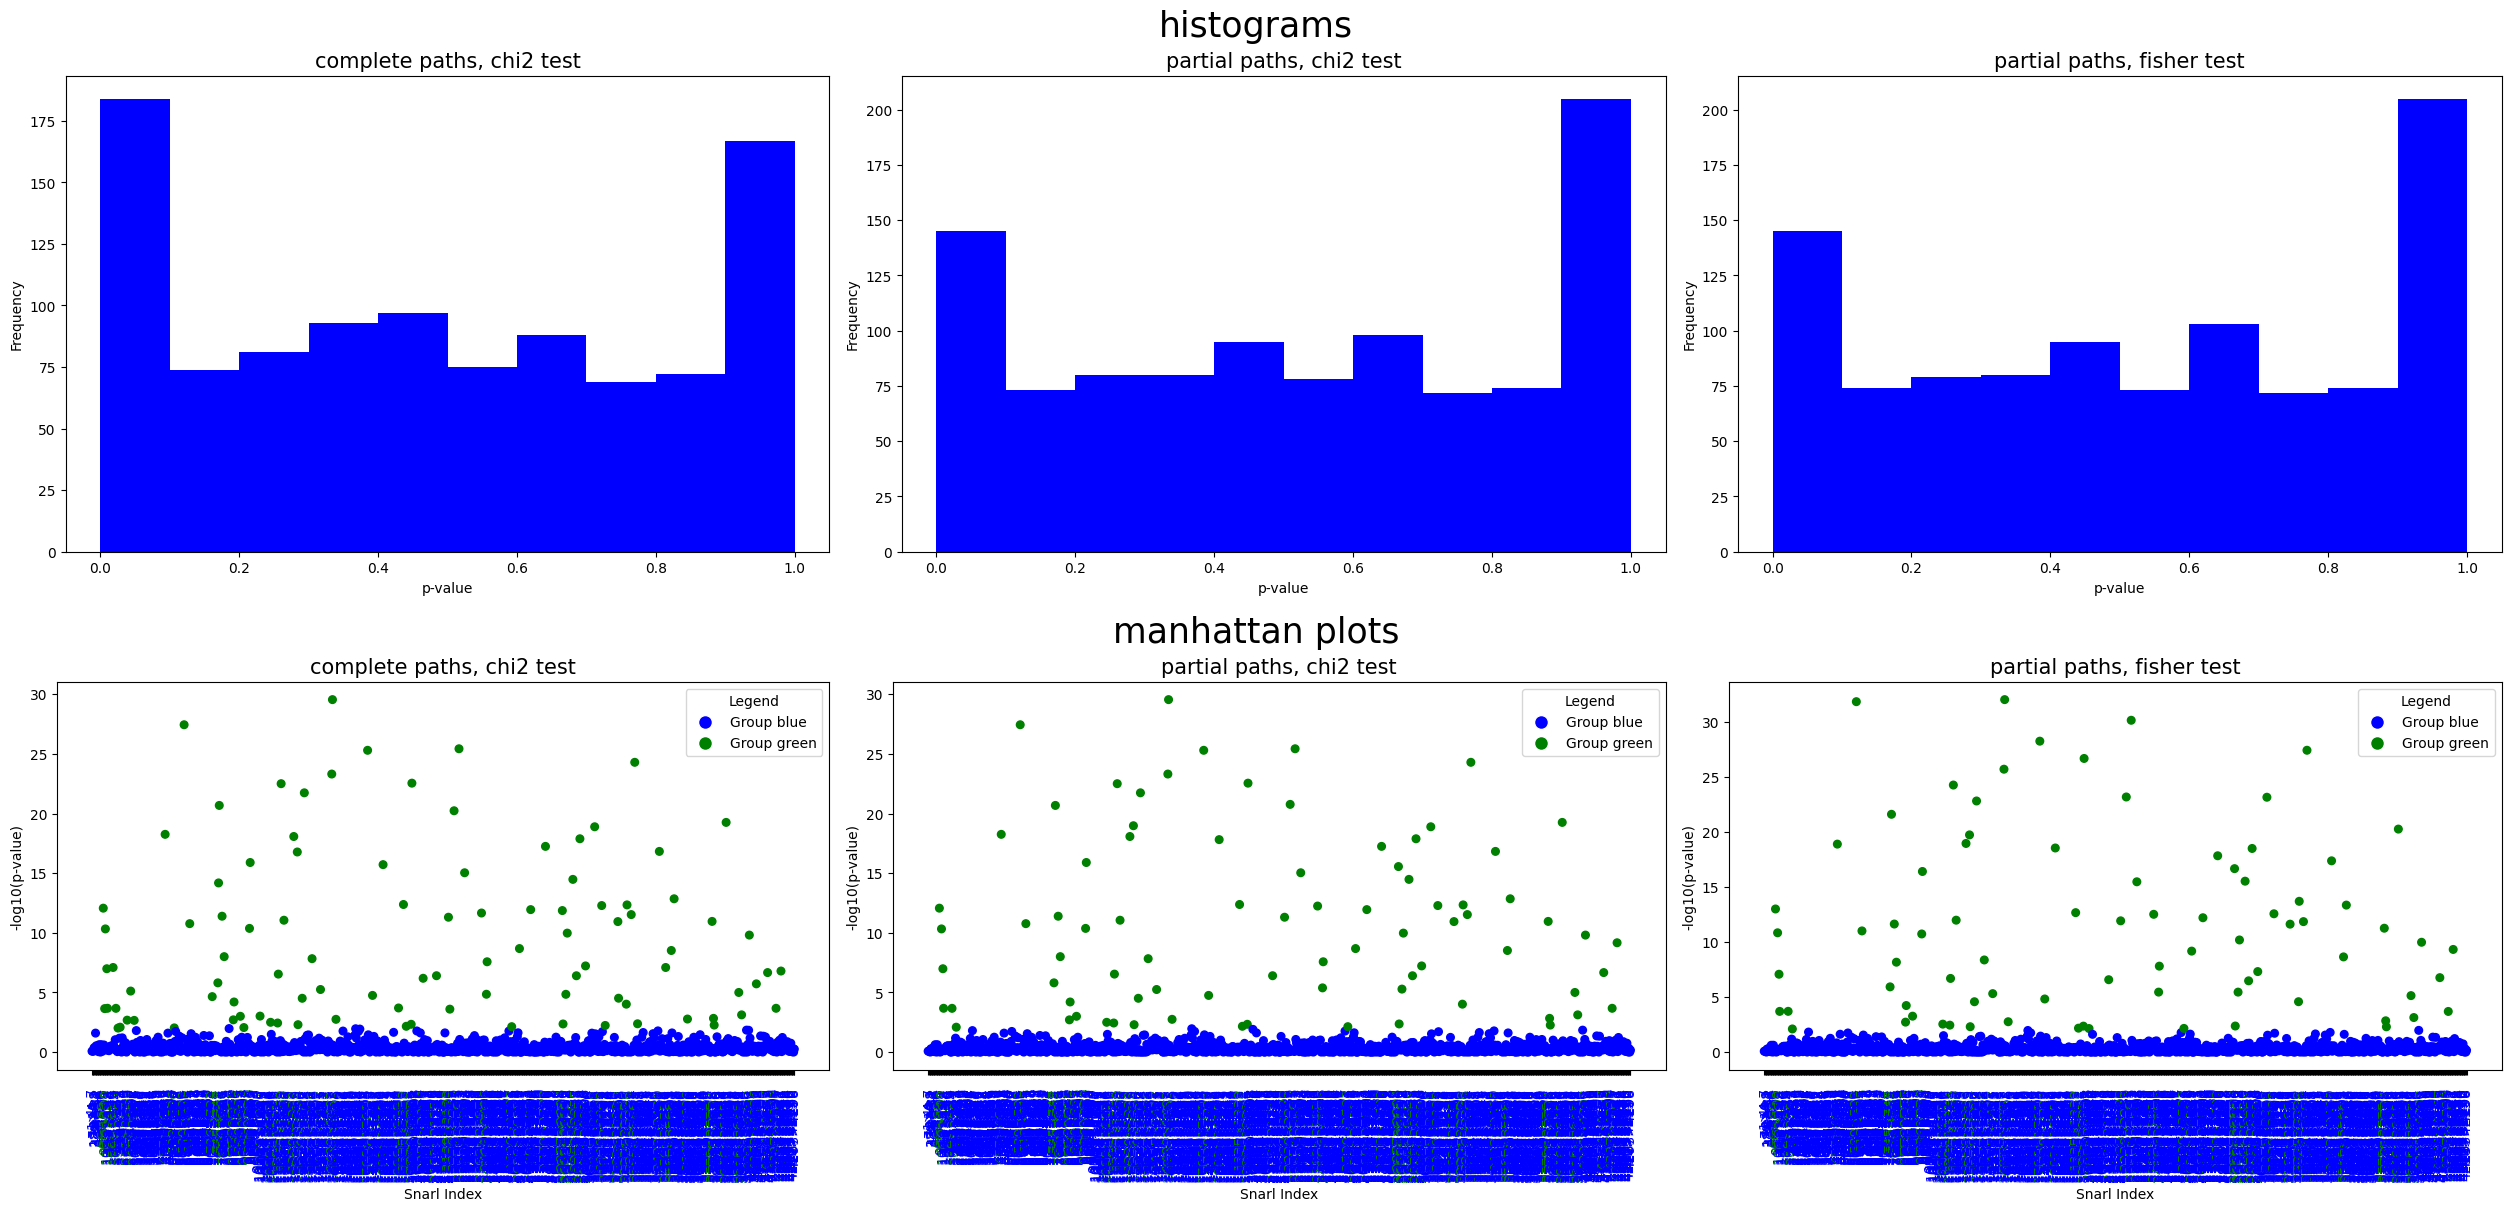

In [20]:
fig = plt.figure(constrained_layout=True)
fig.set_figheight(12)
fig.set_figwidth(25)
# fig.suptitle('title')

subfig_titles = ['histograms', 'manhattan plots']
plot_titles = ['complete paths, chi2 test', 'partial paths, chi2 test', 'partial paths, fisher test']

subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfig_titles[row], fontsize=25)

    # Create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    if row == 0:
        # Add histograms to the first subfig
        histogram(pval_df_complete_chi2, axs[0])
        histogram(pval_df_square_chi2, axs[1])
        histogram(pval_df_square_fish, axs[2])
        # Set titles for the first row
        for col, ax in enumerate(axs):
            ax.set_title(plot_titles[col], fontsize=15)
            ax.set_xlabel('p-value')
            ax.set_ylabel('Frequency')
    elif row == 1:
        # Add Manhattan plots to the second subfig
        manhattan_plot(pval_df_complete_chi2, axs[0])
        manhattan_plot(pval_df_square_chi2, axs[1])
        manhattan_plot(pval_df_square_fish, axs[2])
        for col, ax in enumerate(axs):
            ax.set_title(plot_titles[col], fontsize=15)
            ax.set_xlabel('Snarl Index')
            ax.set_ylabel('-log10(p-value)')

In [21]:
# size of all snarls and number of snarls for each size 
# ex: there are 66 snarls where only two paths are possible and 1 snarl with 61 possible paths

length_of_paths = []
for i in list(all_df.index):
    length_of_paths.append(list(all_df.index).count(i))

# occ = [[x,ind.count(x)] for x in set(ind)]

taille_chem = list(set(length_of_paths))
freq_taille = [len(list(group)) for key, group in groupby(sorted(length_of_paths))]
freq_taille = [int(freq_taille[i] / taille_chem[i]) for i in range(len(freq_taille))]

print(taille_chem, freq_taille)

[2, 3, 4, 5, 6, 7, 134, 9, 10, 8, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 34, 35, 38, 39, 41, 46, 47, 50, 56, 61, 66, 73, 75, 88, 100] [825, 59, 2, 32, 3, 2, 0, 19, 2, 1, 3, 1, 5, 9, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]


# Deuxième partie : linking the new tsv to the vcfs

In [26]:
# reading the netgraph paths
# bdsg = pd.read_csv('/home/yboulkaid/Documents/pg.snarl_netgraph.paths.tsv', sep='\t')
bdsg = pd.read_csv('/home/yboulkaid/Documents/sample_data/pgtest.simulation_1000vars_100samps/pg.snarl_netgraph.paths.tsv', sep='\t')
paths_list = bdsg['paths'].tolist()

# getting the possible paths from the vcfs (nb. these paths do not include nested snarls ie. snarls that are contained in bigger snarls)
possible_paths = [paths(i)[0] for i in all_vcf_df]
possible_paths = sum(possible_paths, [])
possible_paths = list(set(possible_paths))

####### getting a list that has the same structure as possible_paths #######
# separating the snarls so that 1 element of the list corresponds to 1 snarl
for i in range(len(paths_list)):
    paths_list[i] = paths_list[i].split(',')
paths_list = sum(paths_list, [])

# deleting the first caracter, which is always '>'
for i in range(len(paths_list)):
    paths_list[i] = paths_list[i][1:]

####### getting the start and end node of each snarl in both lists #######
start_nodes_og = []
start_nodes_bdsg = []
for i in possible_paths:
    s = start_node(i)
    start_nodes_og.append(s)

for i in paths_list:
    s = start_node(i)
    start_nodes_bdsg.append(s)

####### finfing the 'new' snarls, ie. the ones nested in bigger snarls that we did not detect previously #######
new_start_index = []
for i in range((len(start_nodes_bdsg))):
    if start_nodes_bdsg[i] not in start_nodes_og:
        new_start_index.append(i)

new_snarls = [paths_list[i] for i in new_start_index][::-1]

start_nodes_bdsg = list(set(map(int, start_nodes_bdsg)))

In [27]:
# function to create a snarl_df from the netgraph (as opposed to the previous function that creates it from vcf files)

def make_snarl_df_from_ngraph(which_og_df):

    new_df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken', 'index provisoire'])
    
    for i in range(len(new_snarls)):
        new_df.loc[i, 'times taken'] = 0
    
    new_df['snarl'] = new_snarls
    
    # fill 'snarl index' column
    for i in range(len(new_df['snarl index'])):
        s = start_node(new_df['snarl'][i])
        e = end_node(new_df['snarl'][i])
        new_df.loc[i, "snarl index"] = s + '>' + e
        new_df.loc[i, "index provisoire"] = int(s)
    
    new_df.set_index('index provisoire', inplace=True, drop=True)
    new_df.sort_index(inplace=True)
    new_df.reset_index()
    new_df.set_index('snarl index', inplace=True, drop=True)
    
    times_taken = [0] * len(new_df['snarl'])
    for i in range(len(all_df['snarl'])):
        for j in range(len(new_df['snarl'])):
            if new_df['snarl'].iloc[j] in which_og_df['snarl'].iloc[i]:
                # print(new_all_df['snarl'].iloc[j],all_df['snarl'].iloc[i])
                times_taken[j] += which_og_df['times taken'].iloc[i]
    new_df['times taken'] = times_taken
    
    return new_df

In [28]:
new_all_df = make_snarl_df_from_ngraph(all_df)
new_g0_df = make_snarl_df_from_ngraph(g0_df)
new_g1_df = make_snarl_df_from_ngraph(g1_df)

In [47]:
########### tu pourrais create une fonction make_pval_list
########### et une fonction 'print' avec les infos intéressantes qu'on obtien à partir de la liste 

pval_list_bdsg = []

moo = make_contingency_table(new_all_df, new_g0_df, new_g1_df, '2009>2012')
print(moo)

for i in new_all_df.index.unique():
    table = make_contingency_table(new_all_df, new_g0_df, new_g1_df, i) 
    if (table['g0'] == 0).all() or (table['g1'] == 0).all():  # je suis pas sûre de ce or (un and me paraît plus logique mais dans le cas où une colonne est complètement vide on peut pas faire de test MAIS c'est intéressant de savoir que certains des individus du groupe 1 passent par un chemin alors qu'AUCUN du groupe 0 (ex: '2009>2012') )
        pass
    else:
        table_to_modify = table.copy(deep=True)
        mask = (table['g0'] == 0) & (table['g1'] == 0)
        table_to_modify = table_to_modify[~mask]
        pval_list_bdsg.append([chi2(table_to_modify), i])

pval_df_bdsg = make_pval_df(pval_list_bdsg, 'secondary')



#pval_df_bdsg = make_pval_df(pval_list_bdsg)
smallest_pv_bdsg = make_smallest_pv_list(pval_list_bdsg)


               g0 g1
2009>2011>2012  0  1
2009>2010>2012  0  7
len  pval_list_bdsg  :  29
[(6.8893152869460925, '102>105'), (9.171101073233432, '163>166'), (3.048262253041094, '204>207'), (2.806618459333805, '253>256'), (6.500309264257186, '277>280'), (2.240717120599693, '298>301'), (4.232663903885951, '513>516'), (10.009862025989836, '719>722'), (16.009187587112635, '751>754'), (2.506423401843415, '809>812'), (2.9193248578930837, '821>824'), (3.516253853207507, '1589>1592'), (3.600171226053411, '1766>1769'), (4.534924664193658, '1851>1854'), (6.74615227954046, '2060>2063'), (4.730459389516352, '2174>2177'), (5.075514811434163, '2205>2208'), (2.1285647919906694, '2214>2217'), (2.5634946439185176, '2890>2893'), (2.334810817124783, '3029>3032'), (2.31395259313699, '3111>3114'), (7.699277583179653, '3179>3182'), (2.559854739186552, '3278>3281'), (2.331170145935635, '3349>3352'), (7.632451655538493, '3471>3474'), (2.737816214240663, '3602>3605'), (5.825578580406443, '3877>3880'), (2.574290

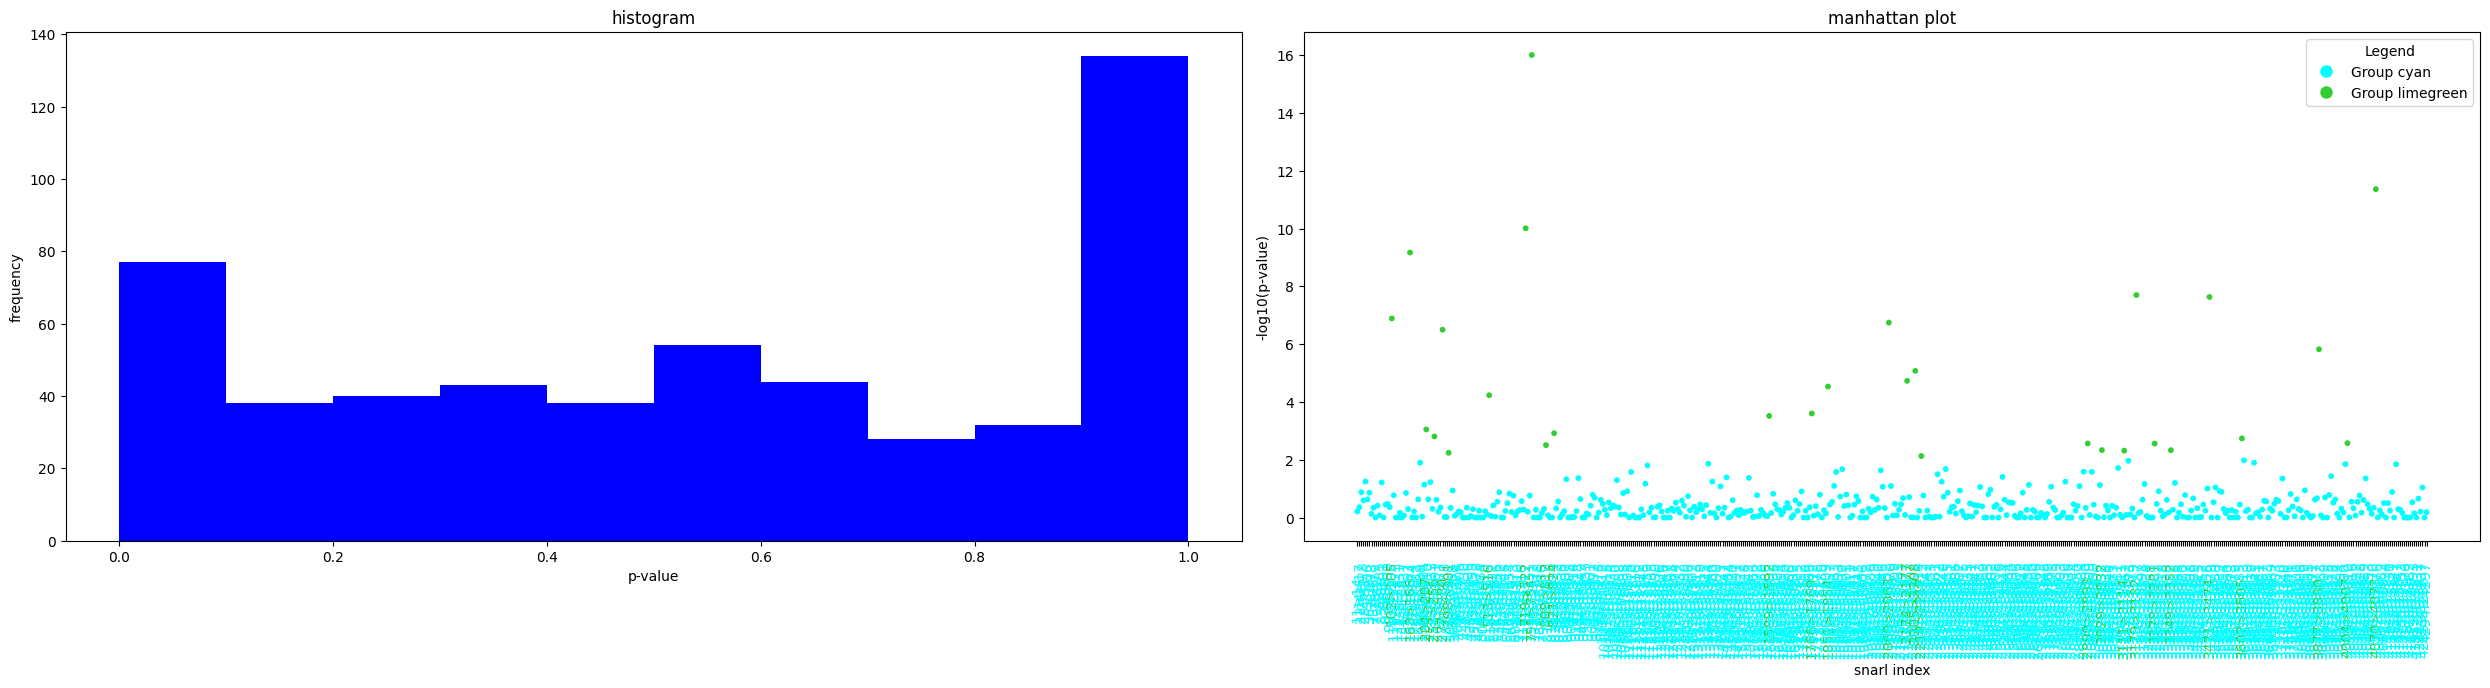

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7))

histogram(pval_df_bdsg, axs[0])
manhattan_plot(pval_df_bdsg, axs[1])

plt.tight_layout()

In [49]:
start_bdsg = [int(start_node(i)) for i in pval_df_bdsg.index]
pval_df_bdsg.insert(0, "temp", start_bdsg, True)

start_other = [int(start_node(i)) for i in pval_df_complete_chi2.index]
pval_df_complete_chi2.insert(0, "temp", start_other, True)
pval_df_complete_chi2

merged_df = pd.concat([pval_df_complete_chi2, pval_df_bdsg])
merged_df = merged_df.sort_values(by=['temp'])


temp   p-value minuslog10pvalue color  size
snarl index                                             
1>4             1  0.838734         0.076376  blue    30
4>7             4   0.83903         0.076223  blue    30
7>10            7    0.8319         0.079929  blue    30
10>18          10  0.426169         0.370418  blue    30
11>14          11   0.61849         0.208667  cyan    10
...           ...       ...              ...   ...   ...
4283>4286    4283       1.0             -0.0  cyan    10
4287>4290    4287  0.500123         0.300923  blue    30
4290>4293    4290       1.0             -0.0  blue    30
4293>4298    4293   0.55822         0.253194  blue    30
4294>4297    4294  0.651981         0.185765  cyan    10

[1528 rows x 5 columns]

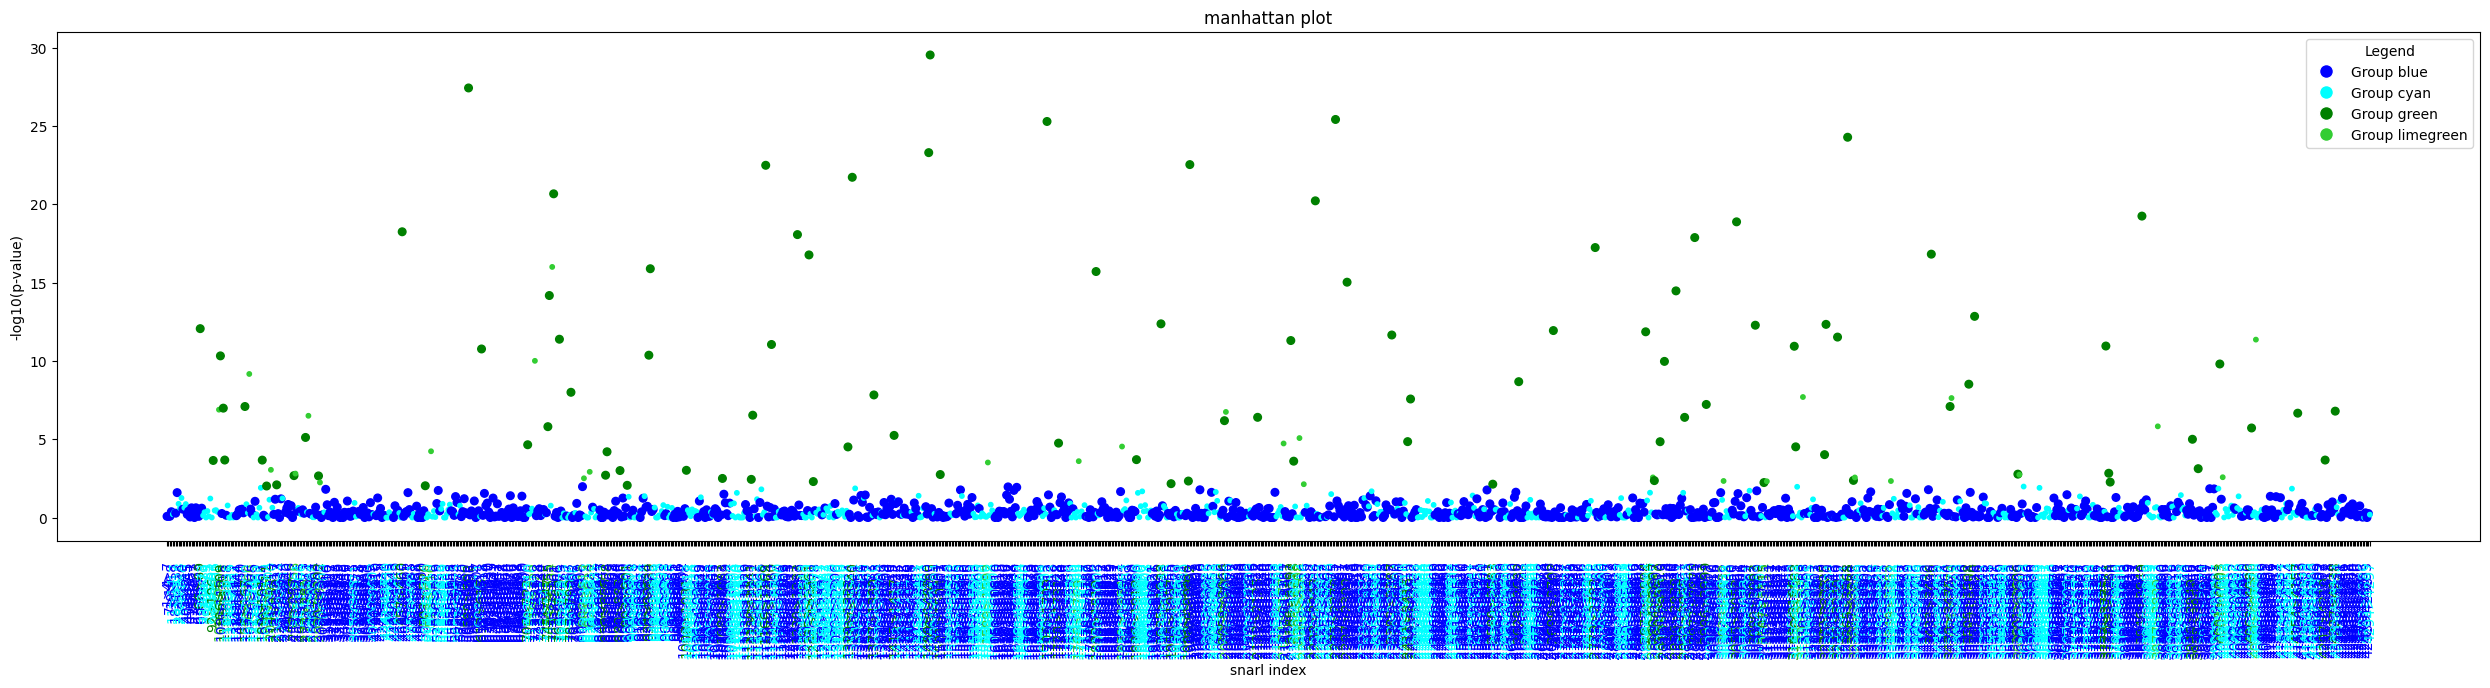

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(25, 7))

#histogram(merged_df, axs[0])
manhattan_plot(merged_df, axs)
unique_colors = merged_df['color'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in unique_colors]
labels = [f'Group {color}' for color in unique_colors]
ax.legend(handles, labels, title='Legend')

plt.tight_layout()

# battling with plots

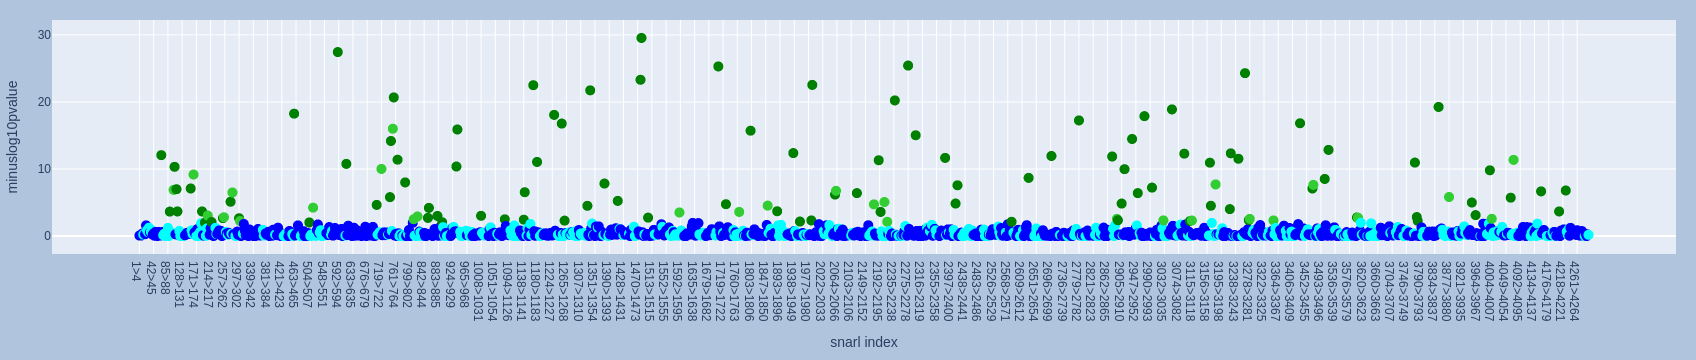

In [51]:
import plotly.express as px

size_max_default = 3
scaling_factor = 4
fig = px.scatter(merged_df, x=merged_df.index, y='minuslog10pvalue', color_discrete_sequence=[merged_df['color']], hover_data=['minuslog10pvalue', merged_df.index], labels={"color": "Group"})
fig.update_traces(marker=dict(size=10))
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="LightSteelBlue",)
fig.show()

In [ ]:
# generate a tsv file with the results of the tests

'''pval_df_complete_chi2 = pval_df_complete_chi2.drop(columns='color')
pval_df_square_chi2 = pval_df_square_chi2.drop(columns='color')
pval_df_complete_chi2.to_csv('pval_full_paths', sep='\t', index=True, header=True)
pval_df_square_chi2.to_csv('pval_partial_paths', sep='\t', index=True, header=True)'''